In [4]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
import json
from textblob import TextBlob
import nltk
from scipy import spatial
import torch
en_nlp = spacy.load('en')

In [5]:
train = pd.read_json("DrQA/data/datasets/SQuAD-v1.1-train.json")

In [6]:
valid = pd.read_json("DrQA/data/datasets/SQuAD-v1.1-dev.json")

In [7]:
train.head(3)

,data,version
0,"{'title': 'University_of_Notre_Dame', 'paragra...",1.1
1,"{'title': 'Beyoncé', 'paragraphs': [{'context'...",1.1
2,"{'title': 'Montana', 'paragraphs': [{'context'...",1.1


In [8]:
contexts = []
questions = []
answers_text = []
answers_start = []
for i in range(train.shape[0]):
    topic = train.iloc[i,0]['paragraphs']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question'])
            answers_start.append(q_a['answers'][0]['answer_start'])
            answers_text.append(q_a['answers'][0]['text'])
            contexts.append(sub_para['context'])   
df = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})

In [9]:
df.to_csv("DrQA/data/datasets/train.csv", index = None)

In [10]:
paras = list(df["context"].drop_duplicates().reset_index(drop= True))
sentences = paras

ans = list(df["text"].drop_duplicates().reset_index(drop= True))
answers = ans

q = list(df["question"].drop_duplicates().reset_index(drop= True))
questions = q

ap = list(df["answer_start"].drop_duplicates().reset_index(drop= True))
answer_pos = ap

print(answers[:3])
print(questions[:3])
print(sentences[:3])

['Saint Bernadette Soubirous', 'a copper statue of Christ', 'the Main Building']
['To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'What is in front of the Notre Dame Main Building?', 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?']
['Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', "As at mo

In [11]:
import numpy as np
import time

import torch
import torch.nn as nn

"""
BLSTM (max/mean) encoder
"""

class InferSent(nn.Module):

    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)

        assert self.version in [1, 2]
        if self.version == 1:
            self.bos = '<s>'
            self.eos = '</s>'
            self.max_pad = True
            self.moses_tok = False
        elif self.version == 2:
            self.bos = '<p>'
            self.eos = '</p>'
            self.max_pad = False
            self.moses_tok = True

    def is_cuda(self):
        # either all weights are on cpu or they are on gpu
        return self.enc_lstm.bias_hh_l0.data.is_cuda

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (bsize)
        # sent: (seqlen x bsize x worddim)
        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent_len_sorted = sent_len_sorted.copy()
        idx_unsort = np.argsort(idx_sort)

        idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_sort)
        sent = sent.index_select(1, idx_sort)

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
        sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_unsort)
        sent_output = sent_output.index_select(1, idx_unsort)

        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            if not self.max_pad:
                sent_output[sent_output == 0] = -1e9
            emb = torch.max(sent_output, 0)[0]
            if emb.ndimension() == 3:
                emb = emb.squeeze(0)
                assert emb.ndimension() == 2

        return emb

    def set_w2v_path(self, w2v_path):
        self.w2v_path = w2v_path

    def get_word_dict(self, sentences, tokenize=True):
        # create vocab of words
        word_dict = {}
        sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
        for sent in sentences:
            for word in sent:
                if word not in word_dict:
                    word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with k first w2v vectors
        k = 0
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    if word in [self.bos, self.eos]:
                        word_vec[word] = np.fromstring(vec, sep=' ')

                if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
                    break
        return word_vec

    def build_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        word_dict = self.get_word_dict(sentences, tokenize)
        self.word_vec = self.get_w2v(word_dict)
        print('Vocab size : %s' % (len(self.word_vec)))

    # build w2v vocab with k most frequent words
    def build_vocab_k_words(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        self.word_vec = self.get_w2v_k(K)
        print('Vocab size : %s' % (K))

    def update_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
        assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
        word_dict = self.get_word_dict(sentences, tokenize)

        # keep only new words
        for word in self.word_vec:
            if word in word_dict:
                del word_dict[word]

        # udpate vocabulary
        if word_dict:
            new_word_vec = self.get_w2v(word_dict)
            self.word_vec.update(new_word_vec)
        else:
            new_word_vec = []
        print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

    def get_batch(self, batch):
        # sent in batch in decreasing order of lengths
        # batch: (bsize, max_len, word_dim)
        embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))

        for i in range(len(batch)):
            for j in range(len(batch[i])):
                embed[j, i, :] = self.word_vec[batch[i][j]]

        return torch.FloatTensor(embed)

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        if self.moses_tok:
            s = ' '.join(word_tokenize(s))
            s = s.replace(" n't ", "n 't ")  # HACK to get ~MOSES tokenization
            return s.split()
        else:
            return word_tokenize(s)

    def prepare_samples(self, sentences, bsize, tokenize, verbose):
        sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
                     [self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        n_w = np.sum([len(x) for x in sentences])

        # filters words without w2v vectors
        for i in range(len(sentences)):
            s_f = [word for word in sentences[i] if word in self.word_vec]
            if not s_f:
                import warnings
                warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
                               Replacing by "</s>"..' % (sentences[i], i))
                s_f = [self.eos]
            sentences[i] = s_f

        lengths = np.array([len(s) for s in sentences])
        n_wk = np.sum(lengths)
        if verbose:
            print('Nb words kept : %s/%s (%.1f%s)' % (
                        n_wk, n_w, 100.0 * n_wk / n_w, '%'))

        # sort by decreasing length
        lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
        sentences = np.array(sentences)[idx_sort]

        return sentences, lengths, idx_sort

    def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
        tic = time.time()
        sentences, lengths, idx_sort = self.prepare_samples(
                        sentences, bsize, tokenize, verbose)

        embeddings = []
        for stidx in range(0, len(sentences), bsize):
            batch = self.get_batch(sentences[stidx:stidx + bsize])
            if self.is_cuda():
                batch = batch.cuda()
            with torch.no_grad():
                batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
            embeddings.append(batch)
        embeddings = np.vstack(embeddings)

        # unsort
        idx_unsort = np.argsort(idx_sort)
        embeddings = embeddings[idx_unsort]

        if verbose:
            print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
                    len(embeddings)/(time.time()-tic),
                    'gpu' if self.is_cuda() else 'cpu', bsize))
        return embeddings

    def visualize(self, sent, tokenize=True):

        sent = sent.split() if not tokenize else self.tokenize(sent)
        sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

        if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
            import warnings
            warnings.warn('No words in "%s" have w2v vectors. Replacing \
                           by "%s %s"..' % (sent, self.bos, self.eos))
        batch = self.get_batch(sent)

        if self.is_cuda():
            batch = batch.cuda()
        output = self.enc_lstm(batch)[0]
        output, idxs = torch.max(output, 0)
        # output, idxs = output.squeeze(), idxs.squeeze()
        idxs = idxs.data.cpu().numpy()
        argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

        # visualize model
        import matplotlib.pyplot as plt
        x = range(len(sent[0]))
        y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
        plt.xticks(x, sent[0], rotation=45)
        plt.bar(x, y)
        plt.ylabel('%')
        plt.title('Visualisation of words importance')
        plt.show()

        return output, idxs

"""
BiGRU encoder (first/last hidden states)
"""


class BGRUlastEncoder(nn.Module):
    def __init__(self, config):
        super(BGRUlastEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.GRU(self.word_emb_dim, self.enc_lstm_dim, 1,
                               bidirectional=True, dropout=self.dpout_model)

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: seqlen x batch x worddim

        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        _, hn = self.enc_lstm(sent_packed)
        emb = torch.cat((hn[0], hn[1]), 1)  # batch x 2*nhid

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        emb = emb.index_select(0, torch.cuda.LongTensor(idx_unsort))

        return emb


"""
BLSTM encoder with projection after BiLSTM
"""


class BLSTMprojEncoder(nn.Module):
    def __init__(self, config):
        super(BLSTMprojEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)
        self.proj_enc = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = self.proj_enc(sent_output.view(-1, 2*self.enc_lstm_dim)).view(-1, bsize, 2*self.enc_lstm_dim)
        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            emb = torch.max(sent_output, 0)[0].squeeze(0)

        return emb


"""
LSTM encoder
"""


class LSTMEncoder(nn.Module):
    def __init__(self, config):
        super(LSTMEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=False, dropout=self.dpout_model)

    def forward(self, sent_tuple):
        # sent_len [max_len, ..., min_len] (batch)
        # sent (seqlen x batch x worddim)

        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[1][0].squeeze(0)  # batch x 2*nhid

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        emb = sent_output.index_select(0, torch.cuda.LongTensor(idx_unsort))

        return emb


"""
GRU encoder
"""


class GRUEncoder(nn.Module):
    def __init__(self, config):
        super(GRUEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim =  config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']

        self.enc_lstm = nn.GRU(self.word_emb_dim, self.enc_lstm_dim, 1,
                               bidirectional=False, dropout=self.dpout_model)

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)

        sent_output = self.enc_lstm(sent_packed)[1].squeeze(0)
        # batch x 2*nhid

        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        emb = sent_output.index_select(0, torch.cuda.LongTensor(idx_unsort))

        return emb


"""
Inner attention from "hierarchical attention for document classification"
"""


class InnerAttentionNAACLEncoder(nn.Module):
    def __init__(self, config):
        super(InnerAttentionNAACLEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']


        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1, bidirectional=True)

        self.proj_key = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.proj_lstm = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.query_embedding = nn.Embedding(1, 2*self.enc_lstm_dim)
        self.softmax = nn.Softmax()

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))
        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = sent_output.transpose(0,1).contiguous()

        sent_output_proj = self.proj_lstm(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_key_proj = self.proj_key(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_key_proj = torch.tanh(sent_key_proj)
        # NAACL paper: u_it=tanh(W_w.h_it + b_w)  (bsize, seqlen, 2nhid)

        sent_w = self.query_embedding(torch.LongTensor(bsize*[0]).cuda()).unsqueeze(2) #(bsize, 2*nhid, 1)

        Temp = 2
        keys = sent_key_proj.bmm(sent_w).squeeze(2) / Temp

        # Set probas of padding to zero in softmax
        keys = keys + ((keys == 0).float()*-10000)

        alphas = self.softmax(keys/Temp).unsqueeze(2).expand_as(sent_output)
        if int(time.time()) % 100 == 0:
            print('w', torch.max(sent_w), torch.min(sent_w))
            print('alphas', alphas[0, :, 0])
        emb = torch.sum(alphas * sent_output_proj, 1).squeeze(1)

        return emb


"""
Inner attention inspired from "Self-attentive ..."
"""


class InnerAttentionMILAEncoder(nn.Module):
    def __init__(self, config):
        super(InnerAttentionMILAEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim =  config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1, bidirectional=True)

        self.proj_key = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.proj_lstm = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, bias=False)
        self.query_embedding = nn.Embedding(2, 2*self.enc_lstm_dim)
        self.softmax = nn.Softmax()

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))
        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = sent_output.transpose(0,1).contiguous()
        sent_output_proj = self.proj_lstm(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)
        sent_key_proj = self.proj_key(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)
        sent_key_proj = torch.tanh(sent_key_proj)
        # NAACL : u_it=tanh(W_w.h_it + b_w) like in NAACL paper

        # Temperature
        Temp = 3

        sent_w1 = self.query_embedding(torch.LongTensor(bsize*[0]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys1 = sent_key_proj.bmm(sent_w1).squeeze(2) / Temp
        keys1 = keys1 + ((keys1 == 0).float()*-1000)
        alphas1 = self.softmax(keys1).unsqueeze(2).expand_as(sent_key_proj)
        emb1 = torch.sum(alphas1 * sent_output_proj, 1).squeeze(1)


        sent_w2 = self.query_embedding(torch.LongTensor(bsize*[1]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys2 = sent_key_proj.bmm(sent_w2).squeeze(2) / Temp
        keys2 = keys2 + ((keys2 == 0).float()*-1000)
        alphas2 = self.softmax(keys2).unsqueeze(2).expand_as(sent_key_proj)
        emb2 = torch.sum(alphas2 * sent_output_proj, 1).squeeze(1)

        sent_w3 = self.query_embedding(torch.LongTensor(bsize*[1]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys3 = sent_key_proj.bmm(sent_w3).squeeze(2) / Temp
        keys3 = keys3 + ((keys3 == 0).float()*-1000)
        alphas3 = self.softmax(keys3).unsqueeze(2).expand_as(sent_key_proj)
        emb3 = torch.sum(alphas3 * sent_output_proj, 1).squeeze(1)

        sent_w4 = self.query_embedding(torch.LongTensor(bsize*[1]).cuda()).unsqueeze(2) #(bsize, nhid, 1)
        keys4 = sent_key_proj.bmm(sent_w4).squeeze(2) / Temp
        keys4 = keys4 + ((keys4 == 0).float()*-1000)
        alphas4 = self.softmax(keys4).unsqueeze(2).expand_as(sent_key_proj)
        emb4 = torch.sum(alphas4 * sent_output_proj, 1).squeeze(1)


        if int(time.time()) % 100 == 0:
            print('alphas', torch.cat((alphas1.data[0, :, 0],
                                       alphas2.data[0, :, 0],
                                       torch.abs(alphas1.data[0, :, 0] -
                                                 alphas2.data[0, :, 0])), 1))

        emb = torch.cat((emb1, emb2, emb3, emb4), 1)
        return emb


"""
Inner attention from Yang et al.
"""


class InnerAttentionYANGEncoder(nn.Module):
    def __init__(self, config):
        super(InnerAttentionYANGEncoder, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True)

        self.proj_lstm = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim,
                                   bias=True)
        self.proj_query = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim,
                                    bias=True)
        self.proj_enc = nn.Linear(2*self.enc_lstm_dim, 2*self.enc_lstm_dim,
                                  bias=True)

        self.query_embedding = nn.Embedding(1, 2*self.enc_lstm_dim)
        self.softmax = nn.Softmax()

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple
        bsize = sent.size(1)

        # Sort by length (keep idx)
        sent_len, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent = sent.index_select(1, torch.cuda.LongTensor(idx_sort))
        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len)
        sent_output = self.enc_lstm(sent_packed)[0]
        # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
        # Un-sort by length
        idx_unsort = np.argsort(idx_sort)
        sent_output = sent_output.index_select(1, torch.cuda.LongTensor(idx_unsort))

        sent_output = sent_output.transpose(0,1).contiguous()

        sent_output_proj = self.proj_lstm(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_keys = self.proj_enc(sent_output.view(-1,
            2*self.enc_lstm_dim)).view(bsize, -1, 2*self.enc_lstm_dim)

        sent_max = torch.max(sent_output, 1)[0].squeeze(1)  # (bsize, 2*nhid)
        sent_summary = self.proj_query(sent_max).unsqueeze(1).expand_as(sent_keys)
        # (bsize, seqlen, 2*nhid)

        sent_M = torch.tanh(sent_keys + sent_summary)
        # (bsize, seqlen, 2*nhid) YANG : M = tanh(Wh_i + Wh_avg
        sent_w = self.query_embedding(torch.LongTensor(bsize*[0]).cuda()).unsqueeze(2)
        # (bsize, 2*nhid, 1)

        sent_alphas = self.softmax(sent_M.bmm(sent_w).squeeze(2)).unsqueeze(1)
        # (bsize, 1, seqlen)

        if int(time.time()) % 200 == 0:
            print('w', torch.max(sent_w[0]), torch.min(sent_w[0]))
            print('alphas', sent_alphas[0][0][0:sent_len[0]])
        # Get attention vector
        emb = sent_alphas.bmm(sent_output_proj).squeeze(1)

        return emb



"""
Hierarchical ConvNet
"""
class ConvNetEncoder(nn.Module):
    def __init__(self, config):
        super(ConvNetEncoder, self).__init__()

        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']

        self.convnet1 = nn.Sequential(
            nn.Conv1d(self.word_emb_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )
        self.convnet2 = nn.Sequential(
            nn.Conv1d(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )
        self.convnet3 = nn.Sequential(
            nn.Conv1d(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )
        self.convnet4 = nn.Sequential(
            nn.Conv1d(2*self.enc_lstm_dim, 2*self.enc_lstm_dim, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(inplace=True),
            )



    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (batch)
        # sent: (seqlen x batch x worddim)

        sent, sent_len = sent_tuple

        sent = sent.transpose(0,1).transpose(1,2).contiguous()
        # batch, nhid, seqlen)

        sent = self.convnet1(sent)
        u1 = torch.max(sent, 2)[0]

        sent = self.convnet2(sent)
        u2 = torch.max(sent, 2)[0]

        sent = self.convnet3(sent)
        u3 = torch.max(sent, 2)[0]

        sent = self.convnet4(sent)
        u4 = torch.max(sent, 2)[0]

        emb = torch.cat((u1, u2, u3, u4), 1)

        return emb


"""
Main module for Natural Language Inference
"""


class NLINet(nn.Module):
    def __init__(self, config):
        super(NLINet, self).__init__()

        # classifier
        self.nonlinear_fc = config['nonlinear_fc']
        self.fc_dim = config['fc_dim']
        self.n_classes = config['n_classes']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.encoder_type = config['encoder_type']
        self.dpout_fc = config['dpout_fc']

        self.encoder = eval(self.encoder_type)(config)
        self.inputdim = 4*2*self.enc_lstm_dim
        self.inputdim = 4*self.inputdim if self.encoder_type in \
                        ["ConvNetEncoder", "InnerAttentionMILAEncoder"] else self.inputdim
        self.inputdim = self.inputdim/2 if self.encoder_type == "LSTMEncoder" \
                                        else self.inputdim
        if self.nonlinear_fc:
            self.classifier = nn.Sequential(
                nn.Dropout(p=self.dpout_fc),
                nn.Linear(self.inputdim, self.fc_dim),
                nn.Tanh(),
                nn.Dropout(p=self.dpout_fc),
                nn.Linear(self.fc_dim, self.fc_dim),
                nn.Tanh(),
                nn.Dropout(p=self.dpout_fc),
                nn.Linear(self.fc_dim, self.n_classes),
                )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(self.inputdim, self.fc_dim),
                nn.Linear(self.fc_dim, self.fc_dim),
                nn.Linear(self.fc_dim, self.n_classes)
                )

    def forward(self, s1, s2):
        # s1 : (s1, s1_len)
        u = self.encoder(s1)
        v = self.encoder(s2)

        features = torch.cat((u, v, torch.abs(u-v), u*v), 1)
        output = self.classifier(features)
        return output

    def encode(self, s1):
        emb = self.encoder(s1)
        return emb


"""
Main module for Classification
"""


class ClassificationNet(nn.Module):
    def __init__(self, config):
        super(ClassificationNet, self).__init__()

        # classifier
        self.nonlinear_fc = config['nonlinear_fc']
        self.fc_dim = config['fc_dim']
        self.n_classes = config['n_classes']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.encoder_type = config['encoder_type']
        self.dpout_fc = config['dpout_fc']

        self.encoder = eval(self.encoder_type)(config)
        self.inputdim = 2*self.enc_lstm_dim
        self.inputdim = 4*self.inputdim if self.encoder_type == "ConvNetEncoder" else self.inputdim
        self.inputdim = self.enc_lstm_dim if self.encoder_type =="LSTMEncoder" else self.inputdim
        self.classifier = nn.Sequential(
            nn.Linear(self.inputdim, 512),
            nn.Linear(512, self.n_classes),
        )

    def forward(self, s1):
        # s1 : (s1, s1_len)
        u = self.encoder(s1)

        output = self.classifier(u)
        return output

    def encode(self, s1):
        emb = self.encoder(s1)
        return emb

In [12]:
MODEL_PATH = 'DrQA/data/models/infersent.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
infersent.set_w2v_path("DrQA/data/embeddings/glove.840B.300d.txt")

In [13]:
infersent.build_vocab(sentences, tokenize=True)

Found 89000(/109693) words with w2v vectors
Vocab size : 89000


In [81]:
#find the individual sentences with help of the TextBlob tokenizer
blob = TextBlob(" ".join(sentences))
sentences = [item.raw for item in blob.sentences]
print(len(sentences))

92651


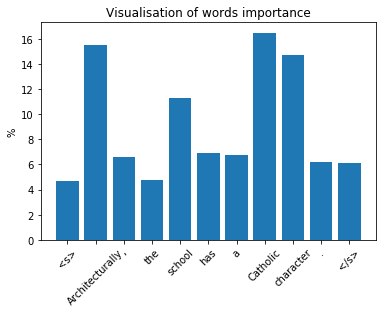

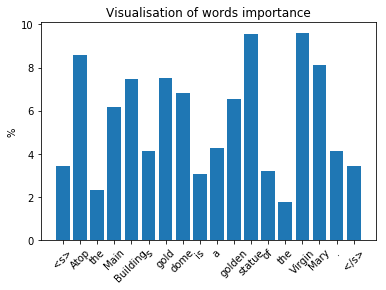

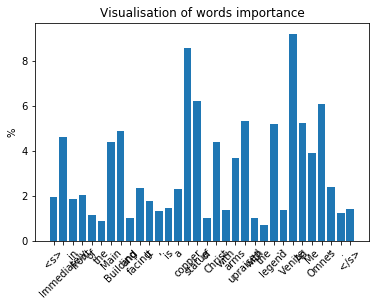

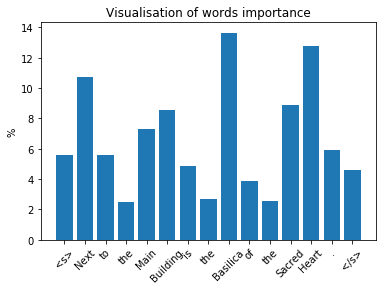

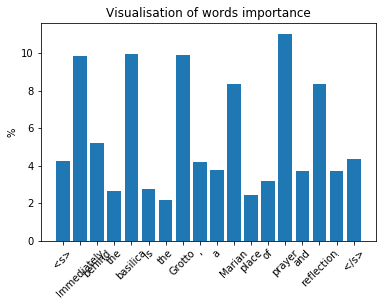

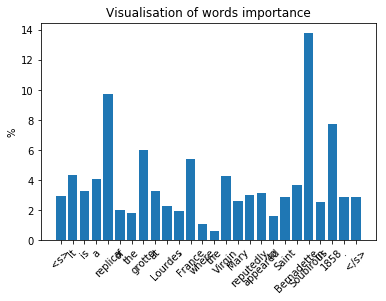

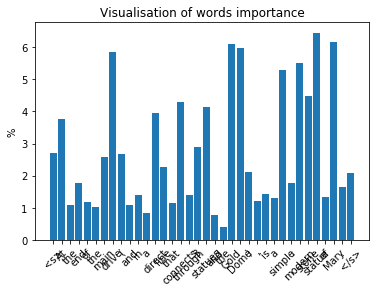

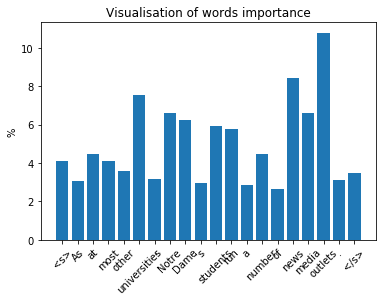

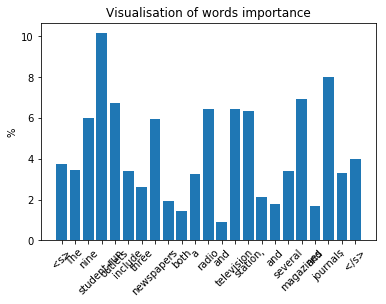

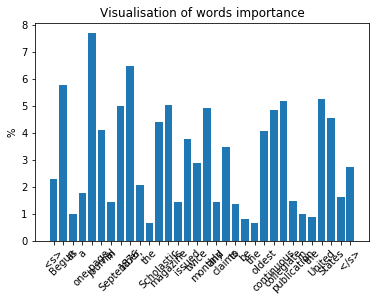

In [ ]:
dict_embeddings = {}
for i in range(len(sentences)):
    #print(i)
    dict_embeddings[sentences[i]] = infersent.encode([sentences[i]], tokenize=True)
    if i<10:
        infersent.visualize(sentences[i], tokenize=True)

In [ ]:
for i in range(len(questions)):
    print(i)
    dict_embeddings[questions[i]] = infersent.encode([questions[i]], tokenize=True)

In [ ]:
d1 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 0}
d2 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 1}

In [ ]:
with open('embeddings/infersent_dict_embeddings1.pickle', 'wb') as handle:
    pickle.dump(d1, handle)

with open('embeddings/infersent_dict_embeddings2.pickle', 'wb') as handle:
    pickle.dump(d2, handle)

In [16]:
def types_in_common(query_words, sentence):
    A = set(query_words)
    B = set(sentence)
    return len(A.intersection(B))

def jaccard(query_words, sentence):
    A = set(query_words)
    B = set(sentence)
    return float(len(A.intersection(B)))/len(A.union(B))

In [17]:
sentences_lower = [w.lower() for w in sentences]

In [18]:
from operator import itemgetter
def run_search(query, similarity_measure, sentences):
    query_words = nltk.word_tokenize(query)
    query_words = [w.lower() for w in query_words]
    sent_scores = [(sent, similarity_measure(query_words, nltk.word_tokenize(sent)))
                   for sent in sentences_lower]
    sent_scores = sorted(sent_scores, key=itemgetter(1), reverse=True)
    sent_scores = [(sent, score) for sent, score in sent_scores if score > 0]
    return sent_scores

In [19]:
run_search("What is next to the main building",types_in_common,sentences)

[('architecturally, the school has a catholic character. atop the main building\'s gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend "venite ad me omnes". next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858. at the end of the main drive (and in a direct line that connects through 3 statues and the gold dome), is a simple, modern stone statue of mary.',
  6),
 ('whitehead pointed to the limitations of language as one of the main culprits in maintaining a materialistic way of thinking, and acknowledged that it may be difficult to ever wholly move past such ideas in everyday speech. after all, each moment of each person\'s life can hardly be given 

In [20]:
run_search("What is next to the main building",jaccard,sentences)

[('hogeschool is used in belgium and in the netherlands. the hogeschool has many similarities to the fachhochschule in the german language areas and to the ammattikorkeakoulu in finland.',
  0.13043478260869565),
 ('what is known in iranian linguistic history as the "middle iranian" era is thought to begin around the 4th century bce lasting through the 9th century. linguistically the middle iranian languages are conventionally classified into two main groups, western and eastern.',
  0.1282051282051282),
 ('the term iranian is applied to any language which descends from the ancestral proto-iranian language. iranian derives from the persian and sanskrit origin word arya.',
  0.12),
 ('the official language of bern is (the swiss variety of standard) german, but the main spoken language is the alemannic swiss german dialect called bernese german.',
  0.12),
 ('devotion is an important part of the practice of most buddhists. devotional practices include bowing, offerings, pilgrimage, and c

In [21]:
contexts = []
questions = []
answers_text = []
answers_start = []
for i in range(valid.shape[0]):
    topic = valid.iloc[i,0]['paragraphs']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question'])
            answers_start.append(q_a['answers'][0]['answer_start'])
            answers_text.append(q_a['answers'][0]['text'])
            contexts.append(sub_para['context'])   
df_val = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})

In [22]:
paras = list(df_val["context"].drop_duplicates().reset_index(drop= True))
sentences_val = paras

ans = list(df_val["text"].drop_duplicates().reset_index(drop= True))
answers_val = ans

q = list(df_val["question"].drop_duplicates().reset_index(drop= True))
questions_val = q

ap = list(df_val["answer_start"].drop_duplicates().reset_index(drop= True))
answer_pos_val = ap

print(answers_val[:3])
print(questions_val[:3])

['Denver Broncos', 'Carolina Panthers', 'Santa Clara, California']
['Which NFL team represented the AFC at Super Bowl 50?', 'Which NFL team represented the NFC at Super Bowl 50?', 'Where did Super Bowl 50 take place?']


In [23]:
run_search(questions_val[2],jaccard,sentences_val)

[('although the importation of slaves to st helena had been banned in 1792, the phased emancipation of over 800 resident slaves did not take place until 1827, which was still some six years before the british parliament passed legislation to ban slavery in the colonies.',
  0.06666666666666667),
 ('the percentage of students attending a gesamtschule varies by bundesland. in the state of brandenburg more than 50% of all students attended a gesamtschule in 2007, while in the state of bavaria less than 1% did.',
  0.06060606060606061),
 ('on february 6, 2016, one day before her performance at the super bowl, beyoncé released a new single exclusively on music streaming service tidal called "formation".',
  0.05714285714285714),
 ('other major sporting events include thoroughbred and quarter horse racing circuits at remington park and numerous horse shows and equine events that take place at the state fairgrounds each year. there are numerous golf courses and country clubs spread around the

In [25]:
import torch
import code
import argparse
import logging
import prettytable
import time
from drqa.reader import Predictor
# ------------------------------------------------------------------------------
# Drop in to interactive mode
# ------------------------------------------------------------------------------
predictor = Predictor('DrQA/data/reader/single.mdl', 'spacy', num_workers=0,
                      normalize=not False)

def process(document, question, candidates=None, top_n=1):
    t0 = time.time()
    predictions = predictor.predict(document, question, candidates, top_n)
    table = prettytable.PrettyTable(['Rank', 'Span', 'Score'])
    for i, p in enumerate(predictions, 1):
        table.add_row([i, p[0], p[1]])
    print(table)
    print('Time: %.4f' % (time.time() - t0))


process(sentences_val[2],questions_val[2])

+------+-------------+---------------------+
| Rank |     Span    |        Score        |
+------+-------------+---------------------+
|  1   | The Broncos | 0.13965517282485962 |
+------+-------------+---------------------+
Time: 7.6190


In [61]:
with open("embeddings/infersent_dict_embeddings1.pickle", "rb") as f:
    d1 = pickle.load(f)
with open("embeddings/infersent_dict_embeddings2.pickle", "rb") as f:
    d2 = pickle.load(f)

In [76]:
dict_emb = dict(d1)
dict_emb.update(d2)
print(dict_emb['Architecturally, the school has a Catholic character.'])

KeyError: 'Architecturally, the school has a Catholic character.'

In [63]:
len(dict_emb)

29430

In [33]:
def get_target(x):
    idx = -1
    for i in range(len(x["sentences"])):
        if x["text"] in x["sentences"][i]: idx = i
    return idx

In [67]:
def process_data(train):
    
    print("step 1: save processed sentences #TextBlobIsAwsome")
    train['sentences'] = train['context'].apply(lambda x: TextBlob(x).sentences)
    
    print("step 2: find the target sentence so we know what we have to look for")
    train["target"] = train.apply(get_target, axis = 1)
    
    print("step 3: save the computed sentence embeddings")
    train['sent_emb'] = train['sentences'].apply(lambda x: [dict_emb[item][0] if item in\
                                                           dict_emb else np.zeros(4096) for item in x])
    print("step 4: save the computed question embeddings")
    train['quest_emb'] = train['question'].apply(lambda x: dict_emb[x] if x in dict_emb else np.zeros(4096) )
        
    return train

In [68]:
train = process_data(df)

step 1: save processed sentences #TextBlobIsAwsome
step 2: find the target sentence so we know what we have to look for
step 3: save the computed sentence embeddings
step 4: save the computed question embeddings


In [69]:
train.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"[(A, r, c, h, i, t, e, c, t, u, r, a, l, l, y,...",5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"[(A, r, c, h, i, t, e, c, t, u, r, a, l, l, y,...",2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"[(A, r, c, h, i, t, e, c, t, u, r, a, l, l, y,...",3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
